In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import scipy

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from fbprophet import Prophet

In [4]:
url = 'https://raw.githubusercontent.com/Srinadh-Vempati/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv'
df = pd.read_csv(url)


In [5]:
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


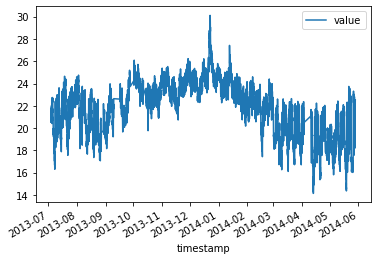

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change °F to °C
df['value'] = (df['value'] - 32) * 5/9
# plot data
df.plot(x='timestamp', y='value')

### Custom Functions

### Feature Engineering
- the hours and if it's night or day (7:00-22:00)
- the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
- An estimation of anomly population of the dataset (necessary for several algorithm)
- time with int to plot easily
- creation of 4 distinct categories that seem useful (week end/day week & night/day)

In [7]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [8]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
outliers_fraction = 0.01

In [9]:
df['time_epoch'] = df['timestamp'].view(np.int64)/1e11
df['time_epoch'] = df['time_epoch'].astype(np.int64)

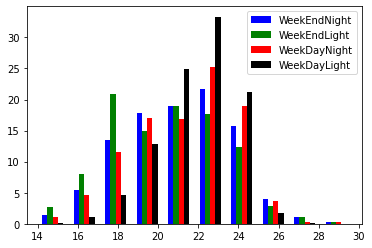

In [10]:
df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()


In [11]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2
...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3


### Models

#### **1. Clustering**

In [12]:
# Features
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# Dimension Reduction
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# Standardization
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [13]:
data

,0,1
0,0.066191,1.755363
1,-0.009413,1.647609
2,-0.009359,1.577677
3,0.061592,1.543184
4,0.031660,1.458262
...,...,...
7262,-0.663130,-0.218870
7263,-0.669607,-0.292067
7264,-0.679271,-0.366858
7265,-0.684664,-0.439514


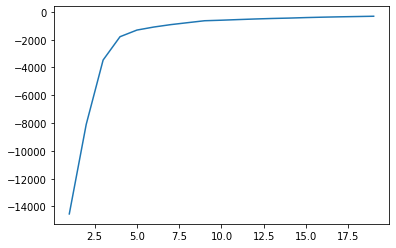

In [14]:
# Optimal number of centriods
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

**Considering number_centroids = 15**

In [15]:
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

12    599
3     596
9     578
5     576
11    574
4     546
6     537
0     520
10    506
7     460
14    400
1     358
2     347
8     339
13    331
Name: cluster, dtype: int64

In [16]:
df.head(5)

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,cluster,principal_feature1,principal_feature2
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2,5,0.066191,1.755363
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2,5,-0.009413,1.647609
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2,5,-0.009359,1.577677
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2,5,0.061592,1.543184
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2,5,0.031660,1.458262


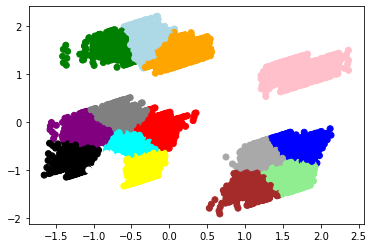

In [17]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

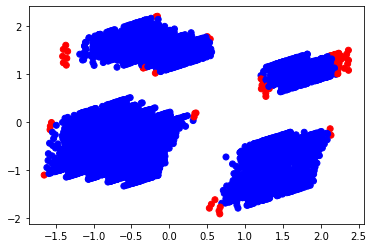

In [18]:
def getDistanceByPoint(data, model):
    distance = pd.Series(np.float32)
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]]
        distance[i] = np.linalg.norm(Xa-Xb)
    return distance

# get the distance between each point and its nearest centroid. 
# The biggest distances are considered as anomaly

distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.astype(np.float32).nlargest(number_of_outliers).min()

# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

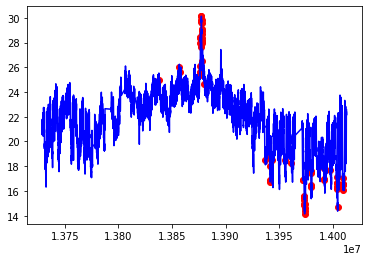

In [19]:
# Time Domain Visualization

fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']]

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

#### **2. Categories + Gaussian**

In [20]:
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

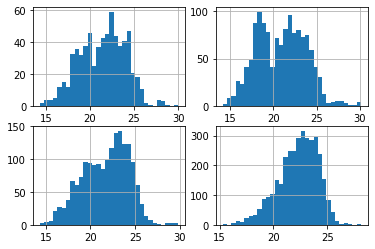

In [21]:
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [22]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


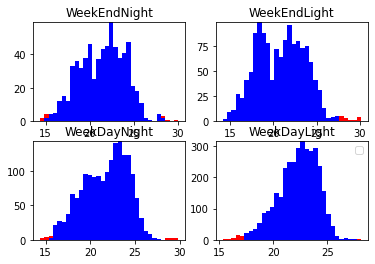

In [23]:
# Visaulization
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

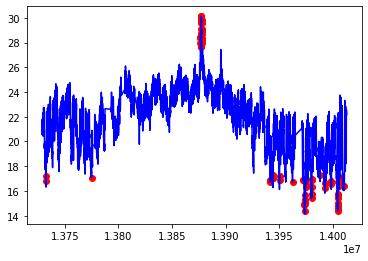

In [24]:
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int)

fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

#### **3. Markov Chains**

We need to discretize the data points in define states for markov chain. We will just take 'value' to define state for this example and define 5 levels of value (very low, low, average, high, very high)/(VL, L, A, H, VH). Markov chain will calculate the probability of sequence like (VL, L, L, A, A, L, A). If the probability is very weak we consider the sequence as an anomaly.

In [25]:
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

In [26]:
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def successProbabilityMetric(state1, state2, transition_matrix):
    proba = 0
    for k in range(0,len(transition_matrix)):
        if (k != (state2-1)):
            proba += transition_matrix[state1-1][k]
    return 1-proba

def sucessScore(sequence, transition_matrix):
    proba = 0 
    for i in range(1,len(sequence)):
        if(i == 1):
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
    return proba

def anomalyElement(sequence, threshold, transition_matrix):
    if (sucessScore(sequence, transition_matrix) > threshold):
        return 0
    else:
        return 1


def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
df_anomaly = markovAnomaly(df_mm, 5, 0.20)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())

0    7147
1     120
dtype: int64


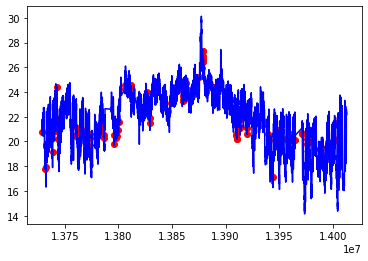

In [27]:
df['anomaly24'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

#### **4. Isolation Forest**

In [28]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


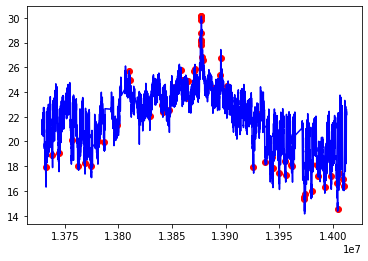

In [29]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

#### **5. One Class SVM**

In [30]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


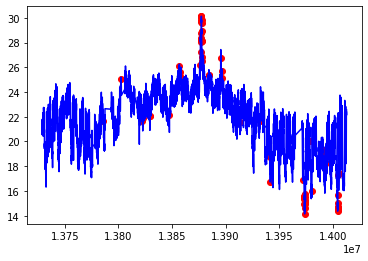

In [31]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

#### **6. RNN**

In [60]:
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut]
y_train = data_n[prediction_time:-testdatacut  ][0]

# test data
x_test = data_n[0-testdatacut:-prediction_time]
y_test = data_n[prediction_time-testdatacut:  ][0]

#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [45]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [41]:
# Build the model
model = Sequential()

model.add(LSTM(units=64,input_shape=(50,5),\
               activation='relu',return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64,activation='relu',return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1,activation='linear'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 64)            17920     
                                                                 
 dropout_6 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51,009
Trainable params: 51,009
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
model.compile(loss='mse',optimizer='adam')

In [44]:
# Train the network
model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/30
92/92 [==============================] - 44s 391ms/step - loss: 0.1980 - val_loss: 0.1394
Epoch 2/30
92/92 [==============================] - 36s 390ms/step - loss: 0.0759 - val_loss: 0.1195


In [61]:
model.evaluate(x_test,y_test)

32/32 [==============================] - 1s 34ms/step - loss: 0.1718


0.17176933586597443

In [63]:
y_test = y_test.to_numpy()

In [66]:
diff=[]
ratio=[]
p = model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

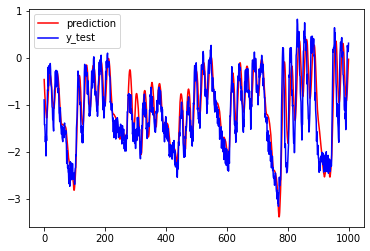

In [67]:
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [68]:
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)

# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))

# add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


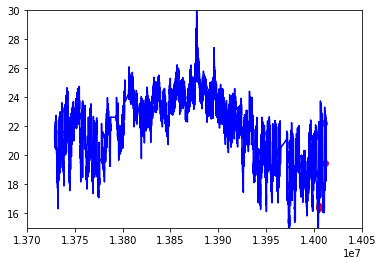

In [69]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()